In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", message=".*Value in checkpoint could not be found in the restored object.*")
from scipy.stats import skew, kurtosis, boxcox
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#libraries to evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from matplotlib.cm import get_cmap
from sklearn.model_selection import GridSearchCV
!pip install keras-tuner --upgrade
from keras_tuner.tuners import RandomSearch
import xgboost as xgb

**Loading Data**

In [ ]:
df_train = pd.read_csv(r'sample_data/train.csv')

## **Exploratory data analysis and Data preprocessing**

In [ ]:
#provides a glimpse of the data
df_train.head()

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier,cost
0,t52712528,2017-09-06,night,NaN,S4,D7,2200,expedited,50,NaN,D,68.413152
1,t29859381,2017-10-21,night,NaN,S8,D1,1800,NaN,12,NaN,B,36.450649
2,t25702332,2017-07-15,night,NaN,S9,D5,2800,NaN,1,NaN,B,9.057939
3,t27713405,2017-10-22,day,NaN,S9,D7,3200,NaN,50,NaN,C,57.320087
4,t49439220,2019-12-11,day,snow,S9,D1,2000,NaN,43,NaN,B,77.263777


In [ ]:
#provides a concise summary of a DataFrame
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38999 entries, 0 to 38998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trip                 38999 non-null  object 
 1   date                 38999 non-null  object 
 2   dayPart              38999 non-null  object 
 3   exWeatherTag         4882 non-null   object 
 4   originLocation       38999 non-null  object 
 5   destinationLocation  38999 non-null  object 
 6   distance             38999 non-null  int64  
 7   type                 3748 non-null   object 
 8   weight               38999 non-null  int64  
 9   packageType          2500 non-null   object 
 10  carrier              38999 non-null  object 
 11  cost                 38999 non-null  float64
dtypes: float64(1), int64(2), object(9)
memory usage: 3.6+ MB


**Summary of descriptive statistics for numerical type**

In [ ]:
#provides a summary of descriptive statistics for each numerical column
df_train.describe()

,distance,weight,cost
count,38999.000000,38999.000000,38999.000000
mean,2004.061643,42.293033,80.972210
std,728.996843,75.473752,180.715055
min,400.000000,1.000000,5.000000
25%,1400.000000,13.000000,38.768742
50%,2000.000000,25.000000,46.468476
75%,2600.000000,39.000000,70.239797
max,3600.000000,500.000000,2019.734797


**Summary of descriptive statistics for numerical type**

In [ ]:
categorical_columns = [ 'dayPart', 'exWeatherTag', 'originLocation',
       'destinationLocation', 'type',  'packageType',
       'carrier']
for col in categorical_columns:
  print('Feature name:', col)
  print('Categories present ->')
  print(df_train[col].value_counts(dropna=False).to_string())
  print('`'*50)

Feature name: dayPart
Categories present ->
night    25904
day      13095
``````````````````````````````````````````````````
Feature name: exWeatherTag
Categories present ->
NaN     34117
snow     3286
heat     1596
``````````````````````````````````````````````````
Feature name: originLocation
Categories present ->
S3    4461
S5    4388
S6    4379
S8    4368
S4    4324
S1    4312
S9    4302
S7    4267
S2    4198
``````````````````````````````````````````````````
Feature name: destinationLocation
Categories present ->
D8    4471
D3    4386
D9    4379
D2    4335
D5    4334
D7    4297
D1    4284
D6    4279
D4    4234
``````````````````````````````````````````````````
Feature name: type
Categories present ->
NaN          35251
expedited     3748
``````````````````````````````````````````````````
Feature name: packageType
Categories present ->
NaN    36499
TT      2500
``````````````````````````````````````````````````
Feature name: carrier
Categories present ->
B    29813
D     3748
C    

**Missing Data analysis**

In [ ]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
packageType,36499,0.935896
type,35251,0.903895
exWeatherTag,34117,0.874817
trip,0,0.000000
date,0,0.000000
dayPart,0,0.000000
originLocation,0,0.000000
destinationLocation,0,0.000000
distance,0,0.000000
weight,0,0.000000


**Data imputation for handling missing values in Categorical features**

In [ ]:
df_train['exWeatherTag'].fillna(value="normal_weather", inplace=True)
df_train['type'].fillna(value='normal_type', inplace=True)
df_train['packageType'].fillna(value='normal_packageType', inplace=True)

In [ ]:
#re calculation of missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
trip,0,0.0
date,0,0.0
dayPart,0,0.0
exWeatherTag,0,0.0
originLocation,0,0.0
destinationLocation,0,0.0
distance,0,0.0
type,0,0.0
weight,0,0.0
packageType,0,0.0


We can move ahead to other stages of data preprocessing

## **Data visualizations**

**Data distribution of numeric types**

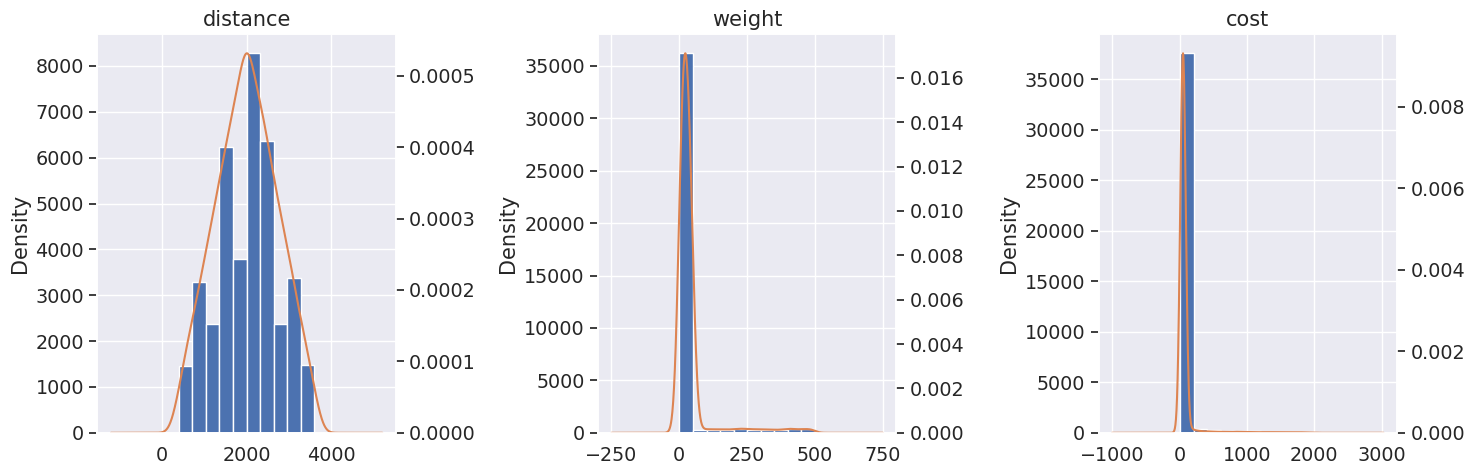

In [ ]:
k = len(df_train[['distance','weight','cost']].columns)

fig, axes = plt.subplots(1,3, figsize=(15,5))
for i, (name, col) in enumerate(df_train[['distance','weight','cost']].items()):
    ax = axes[i]
    col.hist(ax=ax)
    ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name, bw_method=0.2)
    ax2.set_ylim(0)

fig.tight_layout()



**Relationship with numerical variables**

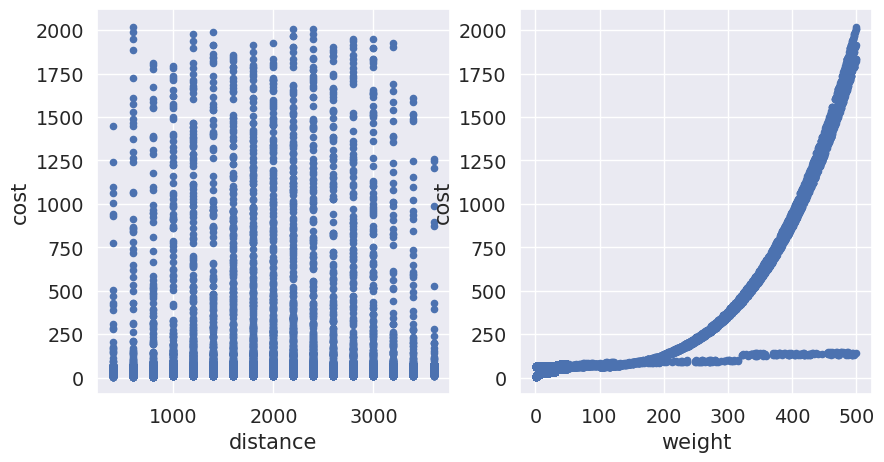

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
data = pd.concat([df_train['cost'], df_train['distance']], axis=1)
data.plot.scatter(y='cost', x='distance', ax=axes[0]);
data = pd.concat([df_train['cost'], df_train['weight']], axis=1)
data.plot.scatter(y='cost', x='weight', ax=axes[1]);

**Feature enginnering distance * weight and visualizing the relationship with cost**

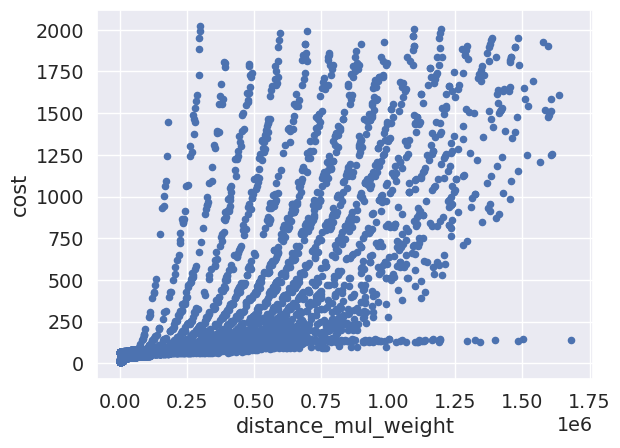

In [ ]:
df_train['distance_mul_weight'] = df_train['distance'].mul(df_train['weight'])
data = pd.concat([df_train['cost'], df_train['distance_mul_weight']], axis=1)
data.plot.scatter(y='cost', x='distance_mul_weight');


**Correlation matrix provides insights into how the features are related to each other.**

<ipython-input-52-2fb0722b4406>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df_train.corr()


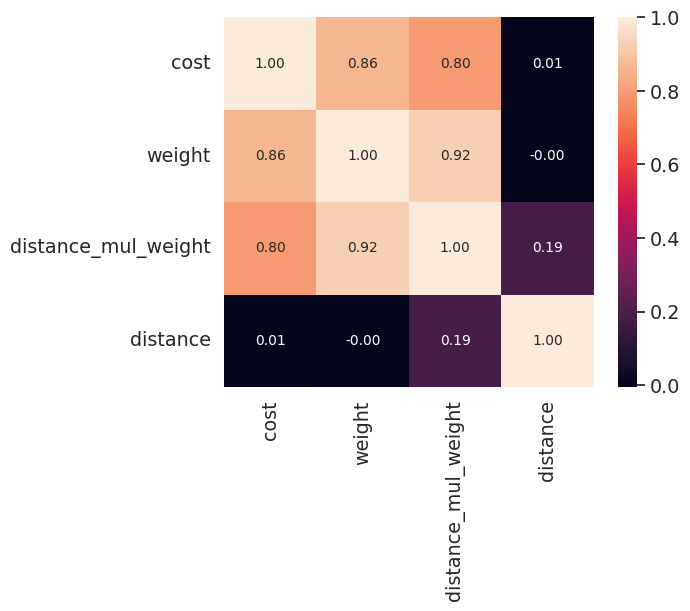

In [ ]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
corrmat = df_train.corr()
cols = corrmat.nlargest(k, 'cost')['cost'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Heatmap is a good way to visualize the correlation. Correlation coefficient ranges from -1 to 1.<br> Poitive values mean positive corelation. <br>negative values mean positive corelation.

In [ ]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d')

df_train['date_day'] = df_train['date'].dt.day
df_train['date_month'] = df_train['date'].dt.month
df_train['date_year'] = df_train['date'].dt.year

**Feature enginnering route as concatenation of originLocation and destinationLocation**

In [ ]:
df_train['route'] = df_train['originLocation'] + df_train['destinationLocation']


In [ ]:
# Encode categorical variables using LabelEncoder and OneHotEncoder
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder()
categorical_columns= ['dayPart', 'exWeatherTag','route' , 'type', 'packageType', 'carrier','date_year', 'date_month', 'date_day']
for column in categorical_columns:
    df_train[column] = label_encoder.fit_transform(df_train[column])
    one_hot_encoded = one_hot_encoder.fit_transform(df_train[column].values.reshape(-1, 1)).toarray()
    num_labels = df_train[column].nunique()
    columns = ['{}_{}'.format(column, i) for i in range(num_labels)]
    df_train[columns] = one_hot_encoded
df_train.columns

<ipython-input-55-78c14f4953d5>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[columns] = one_hot_encoded
<ipython-input-55-78c14f4953d5>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train[columns] = one_hot_encoded
<ipython-input-55-78c14f4953d5>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe =

Index(['trip', 'date', 'dayPart', 'exWeatherTag', 'originLocation',
       'destinationLocation', 'distance', 'type', 'weight', 'packageType',
       ...
       'date_day_20', 'date_day_21', 'date_day_22', 'date_day_23',
       'date_day_24', 'date_day_25', 'date_day_26', 'date_day_27',
       'date_day_28', 'date_day_29'],
      dtype='object', length=156)

In [ ]:
df_train.drop(['dayPart', 'exWeatherTag','originLocation', 'destinationLocation' ,'route', 'type', 'packageType', 'carrier','date_year',  'date_month', 'date_day'], axis=1, inplace=True)

In [ ]:
#checking the columns after one hot encoding and removing the original Object type features
df_train.columns

Index(['trip', 'date', 'distance', 'weight', 'cost', 'distance_mul_weight',
       'dayPart_0', 'dayPart_1', 'exWeatherTag_0', 'exWeatherTag_1',
       ...
       'date_day_20', 'date_day_21', 'date_day_22', 'date_day_23',
       'date_day_24', 'date_day_25', 'date_day_26', 'date_day_27',
       'date_day_28', 'date_day_29'],
      dtype='object', length=145)

**Explore split of data as test and training**

In [ ]:
X = df_train.drop(columns=['cost', 'trip', 'date'])
Y = df_train['cost']
# 80:20 split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=69)

By standardizing the features, StandardScaler ensures that they are on a similar scale, preventing some features from dominating or being biased by their larger values.

In [ ]:
scaler = StandardScaler() #Transforms the data by subtracting by the mean and dividing by the standard deviation,
#resulting in a dataset with zero mean and unit variance.
X_train[['distance_mul_weight', 'weight']] = scaler.fit_transform(X_train[['distance_mul_weight', 'weight']])
X_test[['distance_mul_weight', 'weight']] = scaler.transform(X_test[['distance_mul_weight', 'weight']])


This normalization step is particularly important when working with algorithms that are sensitive to the scale of the features,

**Plotting the distribution of numeric types after applying the standard scalar**

<ipython-input-60-f1fcd71aff96>:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (name, col) in enumerate(X_train[['distance_mul_weight','weight']].iteritems()):


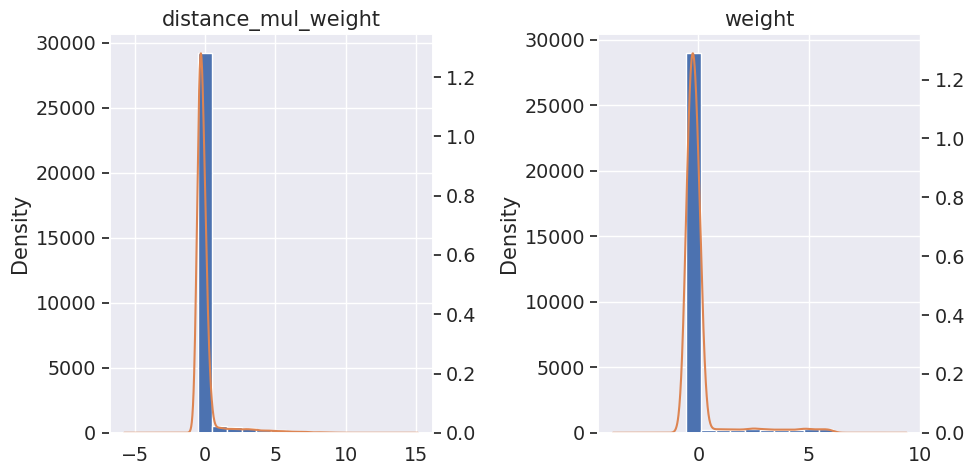

In [ ]:
k = len(X_train[['distance_mul_weight','weight']].columns)

fig, axes = plt.subplots(1,2, figsize=(10,5))
for i, (name, col) in enumerate(X_train[['distance_mul_weight','weight']].iteritems()):
    ax = axes[i]
    col.hist(ax=ax)
    ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name, bw_method=0.2)
    ax2.set_ylim(0)

fig.tight_layout()


# Artificial Neural Network Models

---



In [ ]:
X = df_train.drop(columns=['cost', 'trip', 'date'])
Y = df_train['cost']

# Artificial Neural Network Model

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=69)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Building the ANN model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Adding dropout for regularization
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)  # Regression output
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               18304     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 26,625
Trainable params: 26,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/100
780/780 - 5s - loss: 15149.8027 - val_loss: 9206.1865 - 5s/epoch - 6ms/step
Epoch 2/100
780/780 - 5s - loss: 5972.9219 - val_loss: 4319.2324 - 5s/epoch - 6ms/step
Epoch 3/100
780/780 - 3s - loss: 3299.8721 - val_loss: 2807.7717 - 3s/epoch - 3ms/step
Epoch 4/100
780/780 - 2s - loss: 2270.8667 - val_loss: 1817.2089 - 2s/epoch - 3ms/step
Epoch 5/100
780/780 - 2s - loss: 1439.1133 - val_loss: 1101.9852 - 2s/epoch - 3ms/step
Epoch 6/100
780/780 - 4s - loss: 959.4735 - val_loss: 680.2661 - 4s/epoch - 5ms/step
Epoch 7/100
780/780 - 3s - loss: 662.9191 - val_loss: 444.0452 - 3s/epoch - 4ms/step
Epoch 8/100
780/780 - 2s - loss: 455.1649 - val_loss: 408.4552 - 2s/epoch - 2ms/step
Epoch 9/100
780/780 - 2s - loss: 413.8677 - val_loss: 366.6152 - 2s/epoch - 2ms/step
Epoch 10/100
780/780 - 1s - loss: 415.1249 - val_loss: 313.6346 - 1s/epoch - 2ms/step
Epoch 11/100
780/780 - 1s - loss: 416.0139 - val_loss: 327.7806 - 1s/epoch - 2ms/step
Epoch 12/100
780/780 - 2s - loss: 412.5397 - val_los

In [ ]:
# Predict on the test set
Y_pred = model.predict(X_test)

mse_ann = mean_squared_error(Y_test, Y_pred)
rmse_ann = np.sqrt(mean_squared_error(Y_test, Y_pred))
mae_ann = mean_absolute_error(Y_test, Y_pred)
r2score_ann = r2_score(Y_test, Y_pred)

print("ANN - MSE on test data:", mse_ann)
print("ANN - RMSE on test data:", rmse_ann)
print("ANN - MAE on test data:", mae_ann)
print("ANN - r2 score on test data:", r2score_ann)


244/244 [==============================] - 0s 1ms/step
ANN - MSE on test data: 150.06495670514272
ANN - RMSE on test data: 12.250100273268897
ANN - MAE on test data: 6.137918645247548
ANN - r2 score on test data: 0.9957800145043758


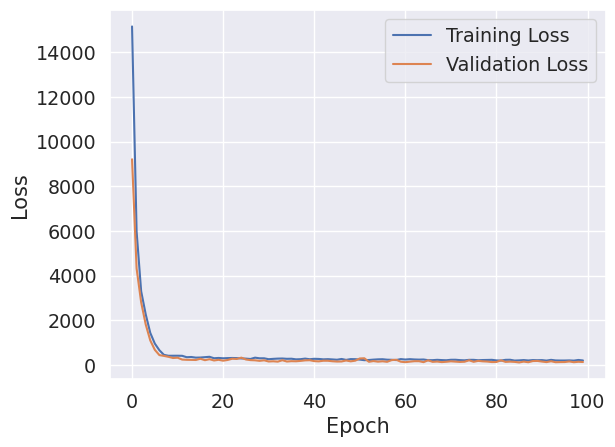

In [ ]:
# Plot training loss and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Artificial Neural Networks with Hypertuning

---



244/244 [==============================] - 1s 2ms/step
Tuned ANN - MSE on test data: 571.2059068378178
Tuned ANN - RMSE on test data: 23.8999143688386
Tuned ANN - MAE on test data: 10.957053881594243
Tuned ANN - r2 score on test data: 0.9839370850144132


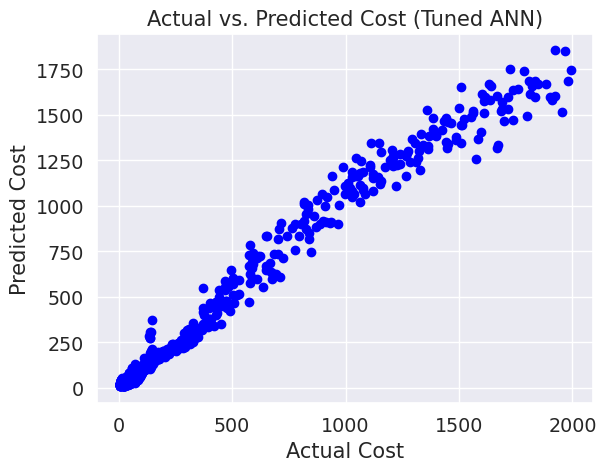

In [ ]:
# Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=69)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hypertuning
def build_model(hp):
    model = tf.keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32),
                                       activation='relu'))
        model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of hyperparameter combinations to try
    directory='tuner_results',
    project_name='ANN_hyperparam_tuning')

tuner.search(X_train, Y_train, epochs=100, validation_split=0.2, verbose=2)

best_model = tuner.get_best_models(num_models=1)[0]

Y_pred = best_model.predict(X_test)

# Evaluate the model using regression metrics
mse_ann_tuned = mean_squared_error(Y_test, Y_pred)
rmse_ann_tuned = np.sqrt(mean_squared_error(Y_test, Y_pred))
mae_ann_tuned = mean_absolute_error(Y_test, Y_pred)
r2score_ann_tuned = r2_score(Y_test, Y_pred)

print("Tuned ANN - MSE on test data:", mse_ann_tuned)
print("Tuned ANN - RMSE on test data:", rmse_ann_tuned)
print("Tuned ANN - MAE on test data:", mae_ann_tuned)
print("Tuned ANN - r2 score on test data:", r2score_ann_tuned)

# Plotting actual vs. predicted values for the tuned ANN model
plt.scatter(Y_test, Y_pred, color='blue')
plt.xlabel('Actual Cost')
plt.ylabel('Predicted Cost')
plt.title('Actual vs. Predicted Cost (Tuned ANN)')
plt.grid(True)
plt.show()


# Random Forest Model

In [ ]:
#K-Folds cross-validator
#Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds
#kf = KFold(n_splits=5, shuffle=True, random_state=69)

rf_model = RandomForestRegressor(random_state=69)

#using only 5000 records as running 5 fold cross validation on total 270 combination is not feasible to complete in one day on complete dataset
rf_model.fit(X_train,Y_train)

RandomForestRegressor(random_state=69)

Random Forest - MSE on test data: 571.2059068378178
Random Forest - RMSE on test data: 23.8999143688386
Random Forest - MAE on test data: 10.957053881594243
Random Forest - r2 score on test data: 0.9839370850144132


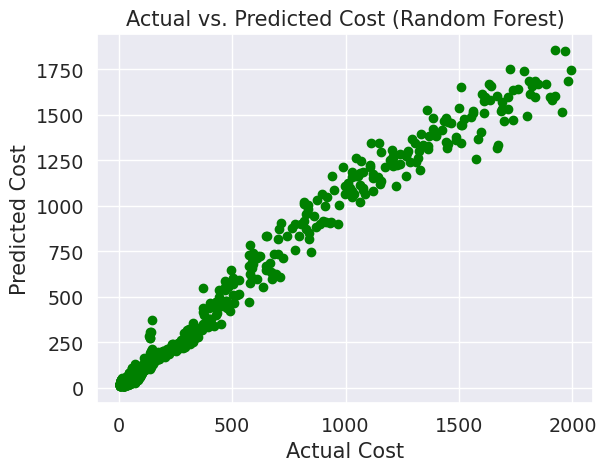

In [ ]:
Y_test_rf = rf_model.predict(X_test)
# Evaluate the model using regression metrics
mse_rfr = mean_squared_error(Y_test, Y_pred)
rmse_rfr = np.sqrt(mean_squared_error(Y_test, Y_pred))
mae_rfr = mean_absolute_error(Y_test, Y_pred)
r2score_rfr = r2_score(Y_test, Y_pred)

print("Random Forest - MSE on test data:", mse_rfr)
print("Random Forest - RMSE on test data:", rmse_rfr)
print("Random Forest - MAE on test data:", mae_rfr)
print("Random Forest - r2 score on test data:", r2score_rfr)

# Plotting actual vs. predicted values for the tuned ANN model
plt.scatter(Y_test, Y_pred, color='green')
plt.xlabel('Actual Cost')
plt.ylabel('Predicted Cost')
plt.title('Actual vs. Predicted Cost (Random Forest)')
plt.grid(True)
plt.show()


# Gradient Boosting Model

In [ ]:
# GradientBoostingRegressor
#K-Folds cross-validator
#Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds
kf = KFold(n_splits=5, shuffle=True, random_state=69)

gb_model = GradientBoostingRegressor(random_state=69)

#using only 5000 records as running 5 fold cross validation on total 270 combination is not feasible to complete in one day on complete dataset
gb_model.fit(X_train,Y_train)


GradientBoostingRegressor(random_state=69)

Gradient Boosting Regressor - MSE on test data: 571.2059068378178
Gradient Boosting Regressor - RMSE on test data: 23.8999143688386
Gradient Boosting Regressor - MAE on test data: 10.957053881594243
Gradient Boosting Regressor - r2 score on test data: 0.9839370850144132


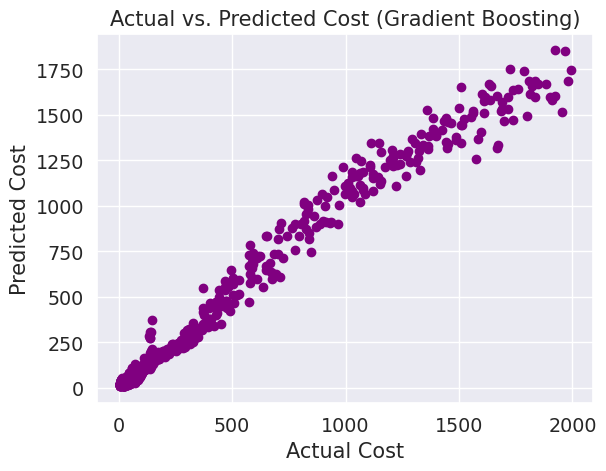

In [ ]:
Y_test_rf = gb_model.predict(X_test)
# Evaluate the model using GradientBoostingmse_ann_tuned = mean_squared_error(Y_test, Y_pred)
mse_gb = mean_squared_error(Y_test, Y_pred)
rmse_gb = np.sqrt(mean_squared_error(Y_test, Y_pred))
mae_gb = mean_absolute_error(Y_test, Y_pred)
r2score_gb = r2_score(Y_test, Y_pred)

print("Gradient Boosting Regressor - MSE on test data:", mse_gb)
print("Gradient Boosting Regressor - RMSE on test data:", rmse_gb)
print("Gradient Boosting Regressor - MAE on test data:", mae_gb)
print("Gradient Boosting Regressor - r2 score on test data:", r2score_gb)

# Plotting actual vs. predicted values for the tuned ANN model
plt.scatter(Y_test, Y_pred, color='purple')
plt.xlabel('Actual Cost')
plt.ylabel('Predicted Cost')
plt.title('Actual vs. Predicted Cost (Gradient Boosting)')
plt.grid(True)
plt.show()


# Checking Best Model According To Their Performance



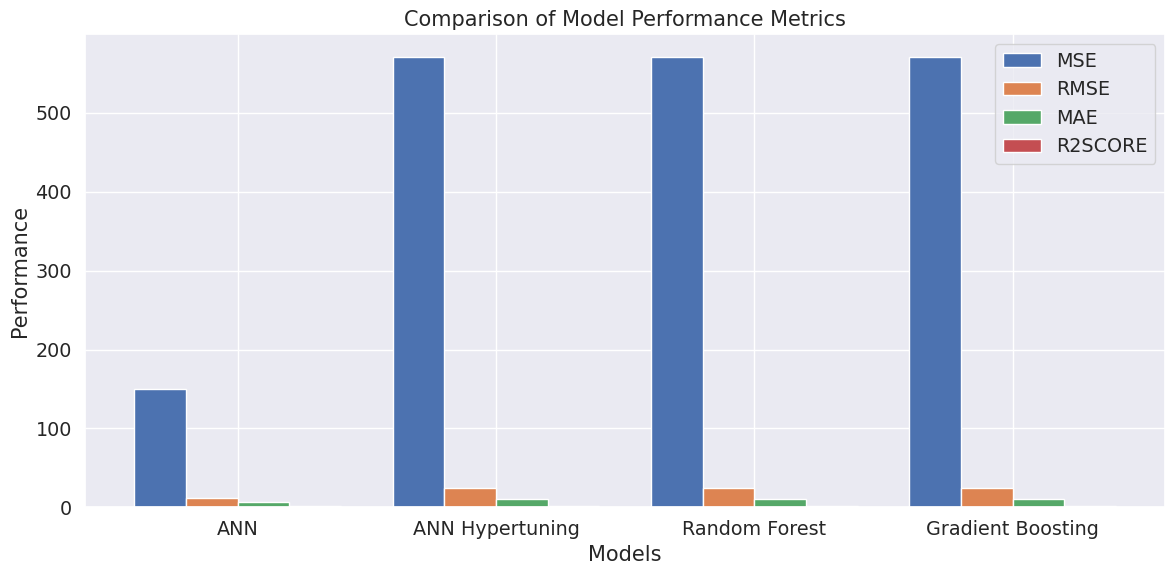

In [ ]:
# Accuracy values for different metrics
mse_accuracies = [mse_ann, mse_ann_tuned, mse_rfr, mse_gb]
rmse_accuracies = [rmse_ann, rmse_ann_tuned, rmse_rfr, rmse_gb]
mae_accuracies = [mae_ann, mae_ann_tuned, mae_rfr, mae_gb]
r2score_accuracies = [r2score_ann, r2score_ann_tuned, r2score_rfr, r2score_gb]

models = ['ANN', 'ANN Hypertuning', 'Random Forest','Gradient Boosting']

bar_width = 0.2
index = np.arange(len(models))

plt.figure(figsize=(12, 6))

plt.bar(index - 1.5*bar_width, mse_accuracies, bar_width, label='MSE')
plt.bar(index - 0.5*bar_width, rmse_accuracies, bar_width, label='RMSE')
plt.bar(index + 0.5*bar_width, mae_accuracies, bar_width, label='MAE')
plt.bar(index + 1.5*bar_width, r2score_accuracies, bar_width, label='R2SCORE')

plt.xlabel('Models')
plt.ylabel('Performance')
plt.title('Comparison of Model Performance Metrics')
plt.xticks(index, models)
plt.legend()
plt.tight_layout()

plt.show()

thank-you-placard-concept-illustration_114360-13436.avif